# YOLOv11 Helmet Detection: Training and Prediction


In [1]:
!pip install uv && uv pip install --upgrade pip && uv pip install -r requirements.txt
!uv pip install datasets ultralytics

'pip' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���
Audited 2 packages in 9ms


In [7]:
import os
import yaml
from ultralytics import YOLO
import matplotlib.pyplot as plt
from IPython.display import Image, display
from datasets import load_dataset
import torch
from pathlib import Path

print("--- Imports Loaded ---")

--- Imports Loaded ---


## Section 1: Load Dataset from Hugging Face

Load the helmet detection dataset from Hugging Face instead of using a local dataset.


Dataset loaded with 13782 training, 3962 validation, and 2001 test examples
Sample example keys: dict_keys(['image_id', 'image', 'width', 'height', 'objects'])
Image dimensions: (640, 640)
Annotations: {'id': [35421], 'area': [27025], 'bbox': [[261.0, 67.0, 129.0, 209.5]], 'category': [0]}


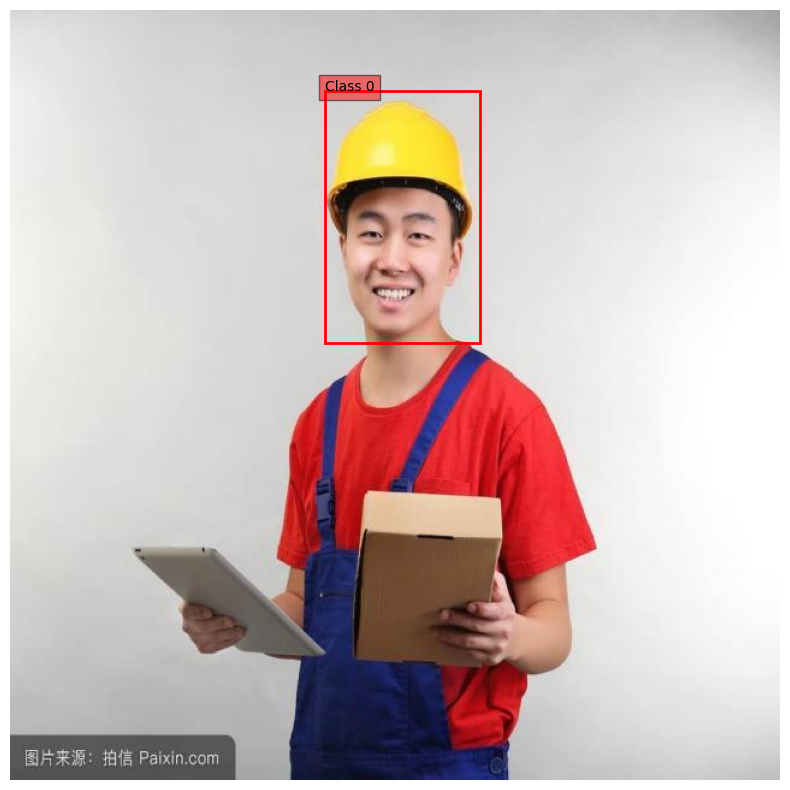

In [3]:
# --- Section 1: Load Dataset from Hugging Face ---
ds = load_dataset("keremberke/hard-hat-detection", name="full")
print(f"Dataset loaded with {len(ds['train'])} training, {len(ds['validation'])} validation, and {len(ds['test'])} test examples")

# Display an example
example = ds['train'][0]
print("Sample example keys:", example.keys())
print(f"Image dimensions: {example['image'].size}")
print(f"Annotations: {example['objects']}")

# Display the first image with its annotations
plt.figure(figsize=(10, 10))
plt.imshow(example['image'])
for i in range(len(example['objects']['id'])):
    bbox_coords = example['objects']['bbox'][i]
    xmin, ymin, width, height = bbox_coords
    xmax, ymax = xmin + width, ymin + height
    category_id = example['objects']['category'][i]
    # Convert category_id to category name if needed
    category = list(class_map.keys())[category_id] if 'class_map' in locals() else f"Class {category_id}"
    plt.gca().add_patch(plt.Rectangle((xmin, ymin), width, height, 
                                    fill=False, edgecolor='red', linewidth=2))
    plt.text(xmin, ymin, category, bbox=dict(facecolor='red', alpha=0.5))
plt.axis('off')
plt.show()

## Section 2: Convert Dataset to YOLO Format

The Hugging Face dataset needs to be converted to a format compatible with YOLO training.


In [4]:
# --- Section 2: Convert Dataset to YOLO Format ---
# Create directories for YOLO dataset
DATASET_DIR = Path('hf_helmet_dataset')
IMAGES_DIR = DATASET_DIR / 'images'
LABELS_DIR = DATASET_DIR / 'labels'

for split in ['train', 'validation', 'test']:
    (IMAGES_DIR / split).mkdir(parents=True, exist_ok=True)
    (LABELS_DIR / split).mkdir(parents=True, exist_ok=True)

# Define class mapping
class_map = {
    'helmet': 0,
    'no-helmet': 1
}

# Function to convert dataset to YOLO format
def convert_to_yolo_format(dataset, split):
    for i, example in enumerate(dataset[split]):
        # Save image
        img = example['image']
        img_path = IMAGES_DIR / split / f"{i}.jpg"
        img.save(img_path)
        
        # Create YOLO format labels
        img_width, img_height = img.size
        label_path = LABELS_DIR / split / f"{i}.txt"
        
        with open(label_path, 'w') as f:
            for j in range(len(example['objects']['id'])):
                # Get bbox coordinates
                bbox_coords = example['objects']['bbox'][j]
                xmin, ymin, width, height = bbox_coords
                
                # Convert to YOLO format (normalized)
                x_center = (xmin + width/2) / img_width
                y_center = (ymin + height/2) / img_height
                width_norm = width / img_width
                height_norm = height / img_height
                
                # Get class id
                category_id = example['objects']['category'][j]
                
                # Write to file
                f.write(f"{category_id} {x_center} {y_center} {width_norm} {height_norm}\n")
    
    return len(dataset[split])

# Convert the datasets
print("Converting dataset to YOLO format...")
train_count = convert_to_yolo_format(ds, 'train')
val_count = convert_to_yolo_format(ds, 'validation')
test_count = convert_to_yolo_format(ds, 'test')
print(f"Converted {train_count} training, {val_count} validation, and {test_count} test examples")

# Create YAML configuration for YOLO
yaml_content = {
    'path': str(DATASET_DIR.absolute()),
    'train': 'images/train',  # Use relative paths instead of absolute
    'val': 'images/validation',  # Use relative paths instead of absolute
    'test': 'images/test',  # Use relative paths instead of absolute
    'nc': len(class_map),
    'names': list(class_map.keys())
}

# Save YAML file
yaml_path = DATASET_DIR / 'data.yaml'
with open(yaml_path, 'w') as f:
    yaml.dump(yaml_content, f)

print(f"Created YOLO configuration at {yaml_path}")
print(yaml_content)

Converting dataset to YOLO format...
Converted 13782 training, 3962 validation, and 2001 test examples
Created YOLO configuration at hf_helmet_dataset\data.yaml
{'path': 'c:\\Users\\Administrator\\HDDS2302_Helmet\\hf_helmet_dataset', 'train': 'images/train', 'val': 'images/validation', 'test': 'images/test', 'nc': 2, 'names': ['helmet', 'no-helmet']}


## Section 3: Define Configuration and Model

Define paths, model variant, and load the base model and dataset configuration.


In [8]:
# --- Section 3: Define Configuration and Model ---
DATA_YAML_PATH = str(yaml_path)  # Use the newly created YAML file
MODEL_VARIANT = 'yolo11n.pt'  # Using YOLOv11 nano variant

# Load the base model
model = YOLO(MODEL_VARIANT)
print(f"Base model '{MODEL_VARIANT}' loaded.")

if torch.backends.mps.is_available():
    DEVICE = 'mps'
    print("Using MPS (Apple Silicon) device")
elif torch.cuda.is_available():
    DEVICE = 'cuda'
    print("Using CUDA device")
else:
    DEVICE = 'cpu'
    print("Using CPU device")

model.to(DEVICE)

# Verify dataset configuration
try:
    with open(DATA_YAML_PATH, 'r') as f:
        data_config = yaml.safe_load(f)
        print("Dataset configuration loaded successfully:")
        print(data_config)
        # Basic validation (check if paths exist)
        required_paths = [
            data_config.get('train'),
            data_config.get('val'),
            data_config.get('test')
        ]
        for p in required_paths:
            if p and not os.path.exists(p):
                print(
                    f"Warning: Path '{p}' specified in {DATA_YAML_PATH} "
                    f"might not exist relative to the current directory."
                )

except Exception as e:
    print(f"Error loading or validating {DATA_YAML_PATH}: {e}")

Base model 'yolo11n.pt' loaded.
Using CUDA device
Dataset configuration loaded successfully:
{'names': ['helmet', 'no-helmet'], 'nc': 2, 'path': 'c:\\Users\\Administrator\\HDDS2302_Helmet\\hf_helmet_dataset', 'test': 'images/test', 'train': 'images/train', 'val': 'images/validation'}


## Section 4: Train the Model

Define training parameters and start the training process using the loaded configuration and base model.


In [ ]:
# --- Section 4: Train the Model ---
# Training parameters
EPOCHS = 50
IMG_SIZE = 640
BATCH_SIZE = 32

print(f"Starting training for {EPOCHS} epochs...")

# Initialize variables for results
results_dir = None
TRAINING_SUCCESS = False

# Start training
try:
    results = model.train(
        data=DATA_YAML_PATH,
        epochs=EPOCHS,
        imgsz=IMG_SIZE,
        batch=BATCH_SIZE,
        device=DEVICE,          # Specify CPU/GPU
        cache=True,             # Cache dataset images in RAM
        amp=True,              # Ensure Automatic Mixed Precision is enabled
        workers=16,             # Number of worker threads
        project='runs/detect',  # Project directory for results
        name='helmet_train'     # Experiment name
    )

    print("Training finished.")
    # Store the results directory for later use
    results_dir = results.save_dir
    print(f"Results saved to: {results_dir}")
    TRAINING_SUCCESS = True

except Exception as e:
    import traceback
    print(f"An error occurred during training: {e}", traceback.format_exc())
    TRAINING_SUCCESS = False

Starting training for 50 epochs...
Ultralytics 8.3.112  Python-3.13.3 torch-2.8.0.dev20250420+cu128 CUDA:0 (NVIDIA GeForce RTX 5080, 16303MiB)
engine\trainer: task=detect, mode=train, model=yolo11n.pt, data=hf_helmet_dataset\data.yaml, epochs=50, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=runs/detect, name=helmet_train16, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, sa

100%|██████████| 755k/755k [00:00<00:00, 1.02MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning C:\Users\Administrator\HDDS2302_Helmet\hf_helmet_dataset\labels\train... 13782 images, 221 backgrounds, 0 corrupt: 100%|██████████| 13782/13782 [00:09<00:00, 1450.89it/s]


train: New cache created: C:\Users\Administrator\HDDS2302_Helmet\hf_helmet_dataset\labels\train.cache
val: Fast image access  (ping: 0.10.1 ms, read: 5.32.0 MB/s, size: 45.6 KB)


val: Scanning C:\Users\Administrator\HDDS2302_Helmet\hf_helmet_dataset\labels\validation... 3962 images, 53 backgrounds, 0 corrupt: 100%|██████████| 3962/3962 [00:03<00:00, 1199.97it/s]


val: New cache created: C:\Users\Administrator\HDDS2302_Helmet\hf_helmet_dataset\labels\validation.cache
Plotting labels to runs\detect\helmet_train16\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\helmet_train16
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      5.03G      1.559      2.078      1.371         54        640: 100%|██████████| 431/431 [00:50<00:00,  8.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:13<00:00,  4.62it/s]


                   all       3962      11174      0.736      0.762      0.762      0.395

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      7.79G      1.488      1.348      1.258         60        640: 100%|██████████| 431/431 [00:49<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:11<00:00,  5.39it/s]


                   all       3962      11174       0.74       0.72      0.724      0.357

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50       7.8G       1.51      1.246      1.277         80        640: 100%|██████████| 431/431 [00:45<00:00,  9.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:10<00:00,  5.72it/s]


                   all       3962      11174      0.658      0.659      0.667      0.332

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50       7.8G      1.573      1.287      1.316        122        640:  17%|█▋        | 73/431 [00:07<00:37,  9.50it/s]


KeyboardInterrupt: 

## Display Training Results

If training completed successfully, display the generated plots and validation images.


In [ ]:
# Display paths to important results files (plots)
if TRAINING_SUCCESS and results_dir:
    print("Displaying training results plots:")

    confusion_matrix_path = os.path.join(results_dir, 'confusion_matrix.png')
    results_plot_path = os.path.join(results_dir, 'results.png')
    val_labels_path = os.path.join(results_dir, 'val_batch0_labels.jpg')
    val_pred_path = os.path.join(results_dir, 'val_batch0_pred.jpg')

    if os.path.exists(confusion_matrix_path):
        print("\nConfusion Matrix:")
        display(Image(filename=confusion_matrix_path))
    else:
        print(f"Confusion matrix not found at: {confusion_matrix_path}")

    if os.path.exists(results_plot_path):
        print("\nResults Plot:")
        display(Image(filename=results_plot_path))
    else:
        print(f"Results plot not found at: {results_plot_path}")

    if os.path.exists(val_labels_path):
        print("\nValidation Batch 0 Labels:")
        display(Image(filename=val_labels_path))
    else:
        print(f"Validation labels image not found at: {val_labels_path}")

    if os.path.exists(val_pred_path):
        print("\nValidation Batch 0 Predictions:")
        display(Image(filename=val_pred_path))
    else:
        print(f"Validation predictions image not found at: {val_pred_path}")
elif not TRAINING_SUCCESS:
    print("Training did not complete successfully. Cannot display results plots.")
else:
    print("Results directory not found. Cannot display results plots.")

Training did not complete successfully. Cannot display results plots.


## Section 7: Load Trained Model and Run Inference

Load the best weights from the completed training run and prepare for inference.


In [ ]:
# --- Section 7: Load Trained Model ---

model_trained = None # Initialize variable

# Only proceed if training seemed to complete and results were saved
if TRAINING_SUCCESS and results_dir:
    # Path to the trained model weights
    TRAINED_MODEL_PATH = os.path.join(results_dir, 'weights/best.pt')

    # Check if the trained model file exists
    if not os.path.exists(TRAINED_MODEL_PATH):
        print(f"Error: Trained model not found at {TRAINED_MODEL_PATH}")
        print("Cannot proceed with inference.")
    else:
        # Load the trained model
        print(f"Loading trained model from {TRAINED_MODEL_PATH}")
        try:
            model_trained = YOLO(TRAINED_MODEL_PATH)
            model_trained.to(DEVICE)
            print("Trained model loaded successfully.")
        except Exception as e:
            print(f"An error occurred during trained model loading: {e}")
            model_trained = None # Ensure it's None if loading failed
else:
    print(
        "Skipping trained model loading because training did not complete successfully "
        "or results directory is unknown."
    )

Skipping trained model loading because training did not complete successfully or results directory is unknown.


### Inference on an Image

Use the loaded trained model to run prediction on a sample image.


In [ ]:
# --- Inference on a Test Image ---

# Get a sample image from the test set (or you can specify your own)
if model_trained:
    try:
        # Try to use a test image from the dataset
        test_example = ds['test'][0]
        test_img = test_example['image']
        test_img_path = 'test_image.jpg'
        test_img.save(test_img_path)
        
        print(f"\nRunning inference on: {test_img_path}")
        
        # Run inference
        predict_results = model_trained.predict(
            source=test_img_path,
            save=True,
            conf=0.5,
            device=DEVICE
        )
        
        # Results are saved in `runs/detect/predict*` directory
        print("Prediction results saved.")

        # Display the saved prediction image
        predict_save_dir = predict_results[0].save_dir
        img_base_name = os.path.basename(test_img_path)
        predicted_image_path = os.path.join(predict_save_dir, img_base_name)

        if os.path.exists(predicted_image_path):
            print("\nDisplaying Prediction Result:")
            display(Image(filename=predicted_image_path))
        else:
             print(f"Could not find saved prediction image at {predicted_image_path}")
            
    except Exception as e:
        print(f"An error occurred during inference: {e}")
elif TRAINING_SUCCESS:
     print("Skipping inference because the trained model failed to load.")
else:
    print("Skipping inference because training did not complete successfully.")

Skipping inference because training did not complete successfully.


In [ ]:
# Optional: Evaluate Model on Test Set
if model_trained:
    try:
        print("\nEvaluating model on test set...")
        metrics = model_trained.val(data=DATA_YAML_PATH, split='test')
        print(f"Model evaluation complete. mAP50-95: {metrics.box.map}")
    except Exception as e:
        print(f"An error occurred during evaluation: {e}")